In [1]:
%run ../ipynb_util_tars.py

In [ ]:
%run ../ipynb_load_data_natural.py

{'SDG': Value(dtype='int64', id=None), 'ABSTRACT': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'sdg_desc_short': Value(dtype='string', id=None), 'sdg_desc_long': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}
Example instance:	 {'SDG': 8, 'ABSTRACT': 'The scheme gives enterprises with business activity in Norway a tax credit on their R&D projects. The R&D content must be approved by the Research Council of Norway ex ante. In 2009, the cap on expenses per enterprise for intramural R&D projects increased to NOK 5.5 million (previously it was N0K 4 million), and NOK11 million (previously it was NOK 8 million) for projects conducted at an R&D institution.', 'id': None, 'sdg_desc_short': None, 'sdg_desc_long': None, '__index_level_0__': 492}
id2label: {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '13', 13: '14', 14: '15', 15: '16', 16: '17'}
label2id: {'1': 0, '2': 1, '

In [ ]:
torch.set_printoptions(precision=6, sci_mode=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

def improved_colored_text_plot(tokens, values, model_name):
    # Normalize values to range [-1, 1]
    max_abs_value = max(abs(min(values)), abs(max(values)))
    normalized_values = [v / max_abs_value for v in values]

    # Create a custom colormap (blue for negative, white for neutral, red for positive)
    colors = ['blue', 'white', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_xlim(0, len(tokens))
    ax.set_ylim(-0.5, 0.5)
    ax.axis('off')

    # Plot colored rectangles and text for each token
    for i, (token, value) in enumerate(zip(tokens, normalized_values)):
        color = cmap((value + 1) / 2)
        rect = Rectangle((i, -0.2), 0.9, 0.4, facecolor=color, edgecolor='none')
        ax.add_patch(rect)
        ax.text(i + 0.45, 0, token, ha='center', va='center', fontsize=8, rotation=90)

    if model_name is not None:
        plt.title("Relevancy scores for model: " + model_name)
    else:
        plt.title('Token Relevancy Visualization')
    plt.tight_layout()
    plt.show()

In [ ]:
"""load pretrained llama"""
import torch
from transformers import AutoTokenizer
from transformers.models.llama.modeling_llama import LlamaForSequenceClassification
from lxt.models.llama import (
    # LlamaForSequenceClassification,
    attnlrp
)

model_name = f"{CHECKPOINT_PATH}/final/meta-llama/Llama-2-7b-hf-noq/checkpoint-632"
#model_name = f"{CHECKPOINT_PATH}/final/meta-llama/Meta-Llama-3-8B-ft-zo_up/checkpoint-2212/"
#model_name = f"{CHECKPOINT_PATH}/TinyLlama/TinyLlama_v1.1/checkpoint-100/"
#model_name = f"{CHECKPOINT_PATH}/TinyLlama/TinyLlama_v1.1/checkpoint-80"
#model_name = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# model = LlamaForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=17,
#     device_map="auto",
#     torch_dtype=torch.bfloat16,
#     token=HF_TOKEN
# )
# model.config.pad_token_id = tokenizer.pad_token_id

# print("Model before AttnLRP rules:", model)

# # apply AttnLRP rules
# print("=" * 40, "\n")
# print("Model after AttnLRP rules:", attnlrp.register(model))


# Use AttnLRP LlamaForSequenceClassification model for comparison
from lxt.models.llama import LlamaForSequenceClassification as LlamaForSequenceClassificationAttnLRP

model_attnlrp = LlamaForSequenceClassificationAttnLRP.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    token=HF_TOKEN
)
model_attnlrp.eval()
print("=" * 40, "\n")
print("AttnLRP llama rules:", model_attnlrp)

from peft import PeftModel

peft_model = PeftModel.from_pretrained(model_attnlrp, model_id=model_name)
model_attnlrp = peft_model.merge_and_unload()

print("=" * 40, "\n")
print("Model after AttnLRP rules:", attnlrp.register(model_attnlrp, verbose=True))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/user/dbielik/msc-thesis/venv_lrp/lib/python3.12/site-packages/torch/nn/modules/module.py:2068: UserWarning: for model.layers.11.self_attn.q_proj.lora_A.default.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/home/user/dbielik/msc-thesis/venv_lrp/lib/python3.12/site-packages/torch/nn/modules/module.py:2068: UserWarning: for model.layers.11.self_attn.q_proj.lora_B.default.weight: copying from a non


AttnLRP llama rules: LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear(
            (base_layer): LinearEpsilon(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): LinearEpsilon(in_features=4096, out_features=4096, bias=False)
          (v_proj): lora.Linear(
            (base_layer): LinearEpsilon(in_features=4096, out_features

OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 74.88 MiB is free. Including non-PyTorch memory, this process has 22.79 GiB memory in use. Process 2232719 has 836.00 MiB memory in use. Of the allocated memory 22.31 GiB is allocated by PyTorch, and 162.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#sample_sentence = "This is about clean energy, and also affordable energy."
sample_sentence = "In terms of regional shares in the OECD area, OECD Europe’s share of consumption is slightly higher than the region’s share of extraction, while the inverse if tme for the OECD America region. The OECD Asia-Oceania region’s share of consumption is the same as its share of extraction. Average income plays a particularly important role. Most of these countries experienced a strong upswing in material extraction starting the early 2000s, although China’s surge began much earlier. By the early 1990s China had overtaken the United States as the world’s largest extractor of material resources."
#sample_sentence = "Ensure access to affordable, reliable, sustainable and modern energy for all"
#sample_sentence = "Tackling supply deficits within individual catchments will be a high cost approach, increasing the requirement for new infrastructure, and requiring more constraint on water use. However, water is heavy and pumping - and carbon - costs are high, so large scale, long distance transfers are expensive, relative to the water’s value. But there is scope for greater interconnection within and between water companies."
#sample_sentence = "Is this about clean energy?"


idx = 2
sample_sentence = dataset["train"][idx]["ABSTRACT"]
print(dataset["train"][idx]["SDG"] + 1)

14


In [ ]:
# Tokenize the sentence
tokenized_output = tokenizer(sample_sentence, return_tensors="pt", add_special_tokens=True)

# Extract token IDs
token_ids = tokenized_output['input_ids'][0].tolist()

# Decode token IDs to readable string
decoded_sentence = tokenizer.decode(token_ids, skip_special_tokens=True)

print("Token IDs:", token_ids)
print("Decoded sentence:", decoded_sentence)

Token IDs: [1, 530, 1342, 338, 278, 16162, 11032, 713, 1383, 761, 321, 3944, 973, 393, 17654, 515, 975, 29888, 14424, 310, 15234, 322, 916, 5962, 9427, 29892, 322, 14161, 2705, 3897, 8022, 630, 491, 2181, 504, 815, 273, 322, 2319, 715, 804, 29873, 440, 20657, 9427, 297, 278, 4688, 29871, 29896, 29929, 29929, 29900, 29879, 313, 7675, 29895, 634, 394, 1696, 19454, 278, 9892, 373, 9427, 292, 1951, 29871, 29896, 29929, 29929, 29941, 29892, 278, 321, 3944, 973, 373, 278, 16162, 11032, 713, 1383, 761, 756, 5229, 304, 9792, 304, 967, 4642, 15259, 310, 9427, 29889, 6549, 29892, 1716, 9427, 6358, 322, 10784, 2454, 22786, 800, 1122, 505, 4100, 27721, 363, 278, 15259, 297, 321, 3944, 973, 29879, 29892, 3704, 278, 409, 370, 287, 7881, 15259, 322, 289, 2660, 24974, 313, 29956, 555, 634, 394, 1696, 4525, 28495, 6403, 472, 1023, 11174, 29901, 316, 552, 9446, 9427, 10961, 29879, 22366, 393, 278, 3438, 310, 9138, 322, 4380, 292, 278, 9427, 338, 6133, 393, 372, 4225, 304, 367, 322, 22338, 975, 5030, 594

In [ ]:
from lxt.utils import clean_tokens
import lxt.functional as lf

model = model_attnlrp

input_ids = tokenizer(
    sample_sentence,
    return_tensors="pt",
    add_special_tokens=True,
).input_ids.to(model.device)
input_embeds = model.get_input_embeddings()(input_ids)

output_logits = model(inputs_embeds=input_embeds.requires_grad_(), use_cache=False).logits
print("output shape", output_logits.shape)

max_logits, max_indices = torch.max(output_logits[0, :], dim=-1)

print(input_embeds.shape)
max_logits.backward(max_logits)
print(input_embeds.grad.shape)
relevance = input_embeds.grad.float().sum(-1).cpu()[0]

# normalize relevance between [-1, 1] for plotting
relevance = relevance / relevance.abs().max()

# remove '_' characters from token strings
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens = clean_tokens(tokens)

out = model.config.id2label[max_indices.item()]
print(max_indices)
print("The label of the sequence is: ", out)

print(tokens)
print(tokenizer.decode(input_ids[0], skip_special_tokens=True))
print(relevance)
improved_colored_text_plot(tokens, relevance, "LLaMA-3 8B (quantized to 8bit during training)")

OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 46.88 MiB is free. Including non-PyTorch memory, this process has 22.81 GiB memory in use. Process 2232719 has 836.00 MiB memory in use. Of the allocated memory 22.38 GiB is allocated by PyTorch, and 116.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import os
print(os.environ['PATH'])

/home/user/dbielik/msc-thesis/venv_lrp/bin:/home/user/dbielik/.vscode-server/cli/servers/Stable-ea1445cc7016315d0f5728f8e8b12a45dc0a7286/server/bin/remote-cli:/home/user/dbielik/miniconda3/bin:/home/user/dbielik/miniconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/games


{'do_lower_case': False, 'unk_token': AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'sep_token': AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'pad_token': AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'cls_token': AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'tokenize_chinese_chars': True, 'strip_accents': None, 'clean_up_tokenization_spaces': True, 'do_basic_tokenize': True, 'model_max_length': 1000000000000000019884624838656, 'never_split': None, 'name_or_path': '/srv/scratch2/dbielik/.cache/huggingface/checkpoints/final/allenai/scibert_scivocab_cased-zo_up/checkpoint-432/', 'max_length': 512, 'truncation_side': 'right', 'stride': 0, 'truncation_strategy': 

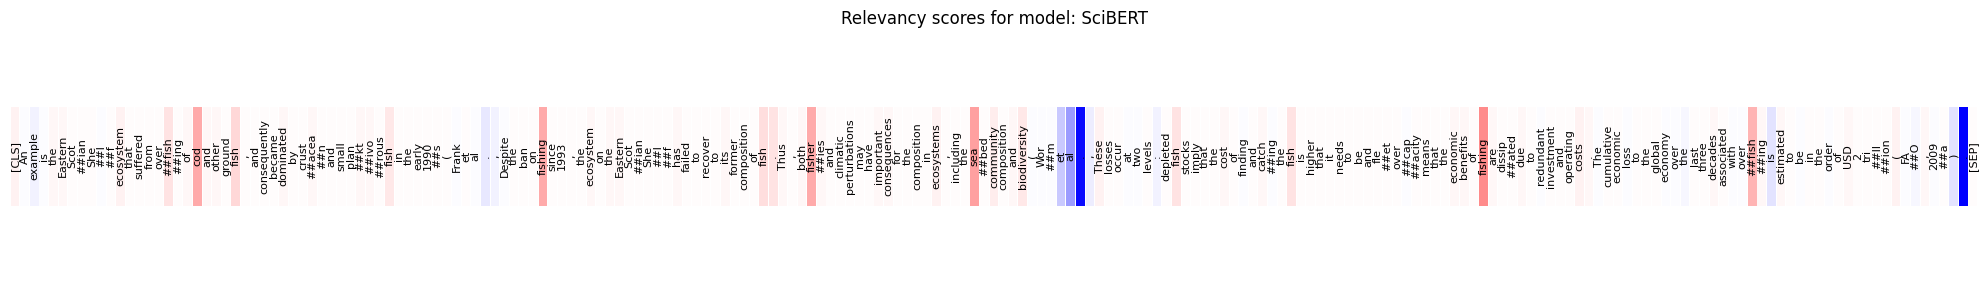

In [ ]:
"""Requires `pip install -e ./lxt`"""
import torch
from transformers import AutoTokenizer
from lxt.models.bert import attnlrp, BertForSequenceClassification
from lxt.utils import pdf_heatmap, clean_tokens

def clean_wordpiece_split(tokens):
        """ BERT-specific cleaning. Workaround not working perfect yet."""
        return [word.replace("##", "") for word in tokens]

def seq_cls():
    """AttnLRP for BERT sequence classification task."""
    SCIBERT_MODEL = CHECKPOINT_PATH + "/final/allenai/scibert_scivocab_cased-zo_up/checkpoint-432/"
    #SCIBERT_MODEL = CHECKPOINT_PATH + "/final-nolowercase/allenai/scibert_scivocab_cased-zo_up/checkpoint-640/"
    tokenizer = AutoTokenizer.from_pretrained(
        SCIBERT_MODEL,
        do_lower_case=False
    )
    print(tokenizer.init_kwargs)
    model = BertForSequenceClassification.from_pretrained(
        SCIBERT_MODEL,
        id2label=id2label,
        label2id=label2id
    ).to(torch.device("cuda"))
    model.eval()

    # apply AttnLRP rules
    attnlrp.register(model)
    tokens = tokenizer(sample_sentence, padding=True, truncation=True, max_length=512, return_tensors="pt", add_special_tokens=True)
    print(tokenizer.convert_ids_to_tokens(tokens.input_ids[0]))
    input_ids = tokenizer(sample_sentence, return_tensors="pt").input_ids.to(torch.device("cuda"))
    inputs_embeds = model.bert.get_input_embeddings()(input_ids)

    logits = model(inputs_embeds=inputs_embeds.requires_grad_()).logits
    print(logits.shape)

    # We explain the sequence label: acceptable or unacceptable
    max_logits, max_indices = torch.max(logits, dim=-1)

    out = model.config.id2label[max_indices.item()]
    print(max_indices)
    print("The label of the sequence is: ", out)

    max_logits.backward(max_logits)

    relevance = inputs_embeds.grad.float().sum(-1).cpu()[0]
    # normalize relevance between [-1, 1] for plotting
    relevance = relevance / relevance.abs().max()

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    tokens = tokens

    #pdf_heatmap(tokens, relevance, path="./heatmap_seq_cls.pdf", backend="xelatex")
    print(type(tokens), tokens)
    print(type(relevance), relevance)

    improved_colored_text_plot(tokens, relevance, "SciBERT")
    #pdf_heatmap(tokens, relevance, path="heatmap_seq_cls.pdf", backend="/home/user/dbielik/texlive/bin/x86_64-linux/xelatex")

seq_cls()

## FinBERT attnlrp on Sentiment classification

In [ ]:
finbert = BertForSequenceClassification.from_pretrained(
    "nickmuchi/finbert-tone-finetuned-fintwitter-classification",
    num_labels=3,
).to("cuda")
finbert.eval()
tokenizer = AutoTokenizer.from_pretrained(
    "nickmuchi/finbert-tone-finetuned-fintwitter-classification"
)

sentence = "Citi gives big boost to Deere PT"
print(finbert(input_ids=tokenizer(sentence, return_tensors="pt").input_ids.to("cuda")))
attnlrp.register(finbert)

input_ids = tokenizer(sentence, return_tensors="pt").input_ids.to(torch.device("cuda"))
inputs_embeds = finbert.bert.get_input_embeddings()(input_ids)

logits = finbert(inputs_embeds=inputs_embeds.requires_grad_()).logits
print(logits.shape)

# We explain the sequence label: acceptable or unacceptable
max_logits, max_indices = torch.max(logits, dim=-1)

out = finbert.config.id2label[max_indices.item()]
print("The label of the sequence is: ", out)

max_logits.backward(max_logits)

relevance = inputs_embeds.grad.float().sum(-1).cpu()[0]
# normalize relevance between [-1, 1] for plotting
relevance = relevance / relevance.abs().max()

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens = clean_tokens(clean_wordpiece_split(tokens))

print(tokens)
print(relevance)
#pdf_heatmap(tokens, relevance, path="./heatmap_seq_cls.pdf", backend="xelatex")


SequenceClassifierOutput(loss=None, logits=tensor([[-4.712738,  2.973304, -2.078524]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
torch.Size([1, 3])
The label of the sequence is:  Bullish
['[CLS]', 'citi', 'gives', 'big', 'boost', 'to', 'deere', 'pt', '[SEP]']
tensor([-0.044548, -0.045781,  0.033255,  0.185055,  1.000000,  0.007080,
        -0.002039,  0.330254, -0.556027])


FileNotFoundError: [Errno 2] No such file or directory: 'xelatex'